# Pre trained model 
Para clasificar imágenes, uno de los modelos preentrenados más populares y efectivos es ResNet (Residual Networks), específicamente ResNet50, que es una red profunda muy eficiente para tareas de clasificación de imágenes.

In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

Usamos image_dataset_from_directory para cargar las imágenes desde directorios

In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wanderdust/skin-lesion-analysis-toward-melanoma-detection")

print("Path to dataset files:", path)

100%|██████████| 11.3G/11.3G [04:36<00:00, 44.0MB/s]  

Extracting files...


Path to dataset files: C:\Users\marta\.cache\kagglehub\datasets\wanderdust\skin-lesion-analysis-toward-melanoma-detection\versions\1


In [52]:
# Directorios de los datasets
train_dir = '/Users/marta/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/train'
validation_dir = '/Users/marta/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/valid'
test_dir = '/Users/marta/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/test'

# Cargar los datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'  # Usamos 'int' para obtener etiquetas como enteros
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False  # No barajamos en el conjunto de prueba
)

Found 2000 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


In [53]:
# Obtener las clases en el conjunto de entrenamiento
class_names = train_dataset.class_names  # Accede a los nombres de las clases

# Obtener las etiquetas del dataset
# Esto es una forma de obtener las clases manualmente
labels = []
for images, label_batch in train_dataset:
    labels.extend(label_batch.numpy())

# Calcular los pesos de las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=np.array(labels)  # `y` debe ser un array con las etiquetas
)

# Convertir los pesos a un diccionario
class_weights_dict = dict(zip(np.arange(len(class_names)), class_weights))

# Imprimir los pesos de las clases
print("Pesos de las clases:", class_weights_dict)

Pesos de las clases: {0: 1.7825311942959001, 1: 0.4859086491739553, 2: 2.6246719160104988}


 Cargamos ResNet50 sin la capa final de clasificación (include_top=False), ya que vamos a agregar nuestra propia capa de clasificación según nuestro número de clases.

 ResNet50 requiere que las imágenes sean redimensionadas a 224x224 píxeles y que sus valores estén normalizados de acuerdo con los valores que fueron utilizados para entrenar el modelo preentrenado

In [54]:
# Cargar el modelo preentrenado ResNet50 sin la capa final de clasificación
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False  # Congelar las capas del modelo base

Añadimos una capa densa con 3 unidades y la activación softmax para clasificación multiclase.

In [55]:
# Crear el modelo completo añadiendo capas para la clasificación
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Promedio global de las características
    layers.Dense(1024, activation='relu'),  # Capa densa para aprender representaciones
    layers.Dense(len(class_names), activation='softmax')  # 3 clases (salida con softmax)
])

In [56]:
# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo usando los pesos de las clases
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    class_weight=class_weights_dict  # Usamos los pesos de clase durante el entrenamiento
)

Epoch 1/10
14/63 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - accuracy: 0.4125 - loss: 2.8934

Entrenamos el modelo con nuestro conjunto de datos

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,  # épocas de entrenamiento
    validation_data=validation_dataset
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.7665 - loss: 0.5658 - val_accuracy: 0.6867 - val_loss: 0.7693
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.7900 - loss: 0.4875 - val_accuracy: 0.6933 - val_loss: 0.6874
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.8328 - loss: 0.4194 - val_accuracy: 0.7200 - val_loss: 0.7518
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8444 - loss: 0.3861 - val_accuracy: 0.7000 - val_loss: 0.7197
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.8551 - loss: 0.3389 - val_accuracy: 0.6467 - val_loss: 0.8458
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.8878 - loss: 0.2933 - val_accuracy: 0.7067 - val_loss: 0.8694
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9204 - loss: 0.2200 - val_accuracy: 0.7267 - val_loss: 0.8544
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9141 - loss: 0.2104 - val_accuracy: 0.6733 - v

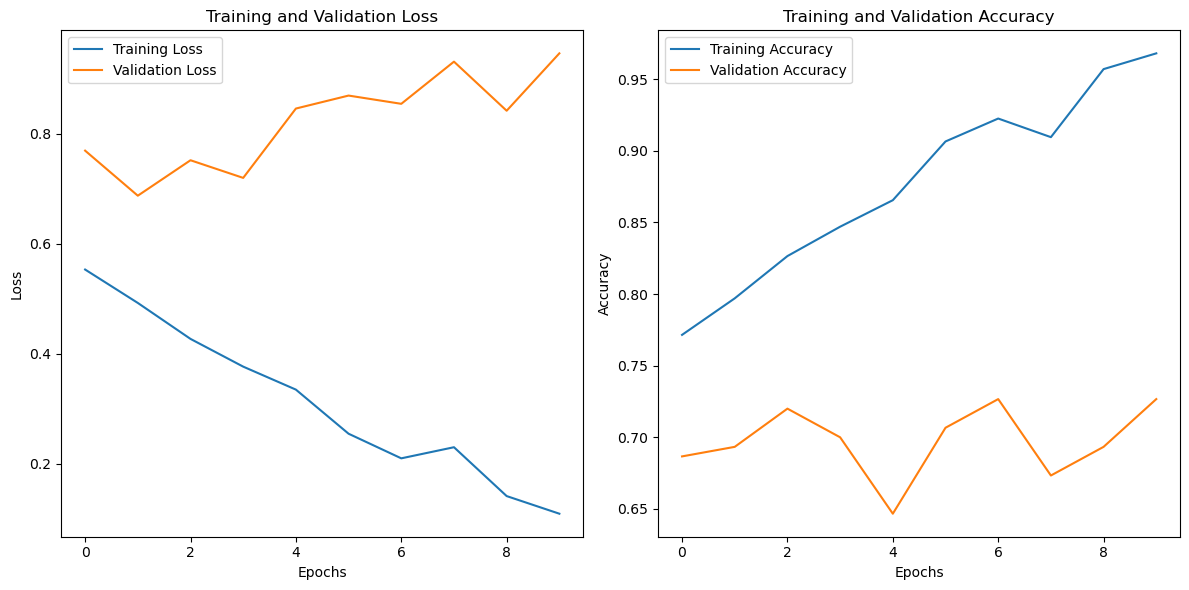

In [ ]:
# Curva de loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
# Evaluamos el modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.6704 - loss: 0.9982
Test Loss: 0.925582766532898
Test Accuracy: 0.6866666674613953


Después de entrenar las capas superiores, hacemos "fine-tuning" desbloqueando algunas capas del modelo base y entrenando nuevamente con una tasa de aprendizaje menor.

In [ ]:

# Fine-tuning del modelo, desbloquear algunas capas y reentrenar
base_model.trainable = True
fine_tune_at = 100  # Elige en qué capa comenzará a entrenar

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar nuevamente con las capas desbloqueadas
model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)